<a href="https://colab.research.google.com/github/HauwaUmar/DATA-6100/blob/main/Project%202%206100%20draft.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 1. Executive Summary

This project is an implementation of binary classification on ‘Spaceship titanic’ data from Kaggle.(https://www.kaggle.com/competitions/spaceship-titanic/overview). 

The aim is to predict which passengers were transported to an alternate dimension by the anomaly using the records provided.

The dataset contained  information about each passenger such as:
- The name of the passenger.
- The age of the passenger.
- The home planet of the passenger.
- Where the passenger planned to arrive.


To start with, basic data exploration was performed to depict certain relationships and trends in the dataset. There seems to be weak correlations between the predictors.

Both the test and train sets held out by Kaggle were combined to perform data cleaning and preprocessing uniformly on the entire data for ease of modeling. 
 The data-cleaning part includes:
 -  Handling missing/NaN values, which was done by filling the NaN values with appropriate imputations.
 - The data needs to be pre-processed before being trained by the model, to transform the categorical variables we have used label encoder and generated dummy variables.

 Four binary classification methods were implemented based on the nature of the dataset
 - Gaussian Naive Bayes 
 - Bernoulli Nave Bayes
 - Linear Discriminant Analysis
 - Logistic Regression

For understanding the importance of variables and selecting the best set of features, feature selection was performed using forward selection and backward elimination for certain models.

After implementing multiple classification models to perform this binary classification task, logistic regression coupled with backward elimination proved to perform the best out of all the others. This produced the highest kaggle submission score of 0.80.

## Best Kaggle Submission 

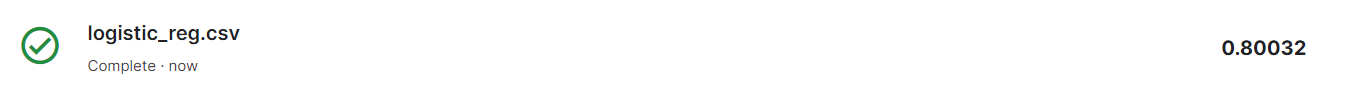

# 2. Ethic Discussion

The dataset was provided by Kaggle and is fictional. However, if we are to push that aside, there are some issues with the provided dataset.
- Personal Information about the passengers i.e. their names were provided in the dataset and was unnecessary for our task. 

- The study of alternate dimensions is extensive and very specific and while conclusions might be made from our model it should be taken with a grain of salt if this happens in real life.



# 3. Detailed Report

## I. Importing libraries

In [1]:
#importing required libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
import itertools
from sklearn.naive_bayes import GaussianNB
from sklearn.naive_bayes import BernoulliNB
from sklearn.linear_model import LogisticRegression
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
import statsmodels.api as sm
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve


## II. Loading dataset

A train and test set were provided to achieve our goal, which will be loaded into dataframes for further analysis.

In [2]:
#reading the held out train and test sets 
train_dataset = pd.read_csv("train.csv")
test_dataset = pd.read_csv("test.csv")

train_dataset.shape, test_dataset.shape

((8693, 14), (4277, 13))

We have 13 explanatory variables. The target is present in the train dataset but not the test dataset.

In [3]:
# combine both testing and training dataset for data cleaning and transformation
whole_dataset = pd.concat((train_dataset, test_dataset)).reset_index(drop = True)

# storing the PassengerId for the test dataset
test_id = test_dataset['PassengerId']

print("The size of the train and test dataset combined: {}".format(whole_dataset.shape))

The size of the train and test dataset combined: (12970, 14)


## III. Exploratory Analysis

The goal is to predict who will and will not be transported. First, we'll conduct some analysis of the data.

Using a histogram, we check how the data in Transported column is distributed.

In [4]:
#plotting a histogram for transported column
px.histogram(train_dataset,x="Transported",color="Transported",width=600,height=400)

There appears to be a balance between those who were transported and those who were not. The rest of the dataset will be explored further.

In [5]:
# information about the dataset
whole_dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12970 entries, 0 to 12969
Data columns (total 14 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   PassengerId   12970 non-null  object 
 1   HomePlanet    12682 non-null  object 
 2   CryoSleep     12660 non-null  object 
 3   Cabin         12671 non-null  object 
 4   Destination   12696 non-null  object 
 5   Age           12700 non-null  float64
 6   VIP           12674 non-null  object 
 7   RoomService   12707 non-null  float64
 8   FoodCourt     12681 non-null  float64
 9   ShoppingMall  12664 non-null  float64
 10  Spa           12686 non-null  float64
 11  VRDeck        12702 non-null  float64
 12  Name          12676 non-null  object 
 13  Transported   8693 non-null   object 
dtypes: float64(6), object(8)
memory usage: 1.4+ MB


There's a combination of numeric and non-numeric columns in the dataset and most columns have missing values which will be handled later.

In [6]:
#statistical description of the data for non-numberic variables
whole_dataset.select_dtypes(include='object').describe()

,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,VIP,Name,Transported
count,12970,12682,12660,12671,12696,12674,12676,8693
unique,12970,3,2,9825,3,2,12629,2
top,0001_01,Earth,False,G/734/S,TRAPPIST-1e,False,Carry Contrevins,True
freq,1,6865,8079,8,8871,12401,2,4378


The  table above shows that there are 3 unique Home Planets and Destinations with most passengers coming from Earth. CryoSleep and VIP are boolean values.Transported is our target variable which also contains boolean values.

In [7]:
#statistical description of the data for numerical variables
whole_dataset.describe()

,Age,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck
count,12700.000000,12707.000000,12681.000000,12664.000000,12686.000000,12702.000000
mean,28.771969,222.897852,451.961675,174.906033,308.476904,306.789482
std,14.387261,647.596664,1584.370747,590.558690,1130.279641,1180.097223
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,19.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,27.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,38.000000,49.000000,77.000000,29.000000,57.000000,42.000000
max,79.000000,14327.000000,29813.000000,23492.000000,22408.000000,24133.000000


The table above depicts  the following:

- On average the age of people on the space ship is 28 with the youngest being 0(probably a new born baby) and the oldest being 79. 

- On average more money was spent at the food court compared to the other options [Room Service, Shopping Mall, Spa, VRDeck].

### CryoSleep

In [8]:
# returning only rows were CryoSleep is not null
cryo_data = train_dataset[~train_dataset['CryoSleep'].isnull()]

#displaying a countplot for CryoSleep, grouped by whether a passenger was transported or not
px.histogram(cryo_data,x="CryoSleep",color="Transported",barmode="group",width=600,height=400)

Based on CryoSleep alone, most people who were not confined to their cabins were not transported. So this is might be an important observation.

### Home Planet

In [9]:
# returning only rows were Home Planet is not null
planet_data = train_dataset[~train_dataset['HomePlanet'].isnull()]

#plotting count plot for each Home planet and grouped by Transported column
px.histogram(planet_data,x="HomePlanet",color="Transported",barmode="group",width=600,height=400)

Majority of the population in the spaceship is from earth. Since we wouldn't anticipate that your place of origin would affect whether you were transported (but who knows what we're dealing with), the distribution between the three planets is noteworthy. Therefore, we wonder if there is any context that is still needed.

### VIP

In [10]:
# returning only rows were VIP is not null
vip_data = train_dataset[~train_dataset['VIP'].isnull()]


#plotting count plot for each VIP status and grouped by Transported column
px.histogram(vip_data,x="VIP",color="Transported",barmode="group",width=600, height=400)

It is obvious that a lot of people would not  be VIP's. However, it seems that the VIP status of a passenger did not play a huge role in whether or not a passenger got transported.

In [11]:
# returning only rows were Destination is not null
destination_data = train_dataset[~train_dataset['Destination'].isnull()]


#plotting count plot for each Destination and grouped by Transported column
px.histogram(destination_data,x="Destination",color="Transported",barmode="group",width=600, height=400)

A lot of passengers planned to arrive at TRAPPIST-1e and more than 50% did not arrive. A higher percentage of passengers that planned to arrive at 55 Cancri e did arrive. And as for PSO J318.5-22, it is significantly equal; the percentage of passengers who arrived and those who didn't. 

### Cabin


In the data description it is stated that each passenger is either on the port side or starboard side on the Cabin. 

An example of the data in this column is 
- A/0/S
- B/0/P
 
There's a pattern present, each data point has 3 sections. The goal is to extract the last section of the pattern that represents the passenger's side.

In [12]:
# spliting getting only the side the passengers cabin were located
train_dataset['Cabin']= train_dataset['Cabin'].apply(lambda x: str(x).split('/')[-1])

#Showing values in Cabin column
train_dataset['Cabin'].unique()

array(['P', 'S', 'nan'], dtype=object)

There is "nan" because there are none values but again that will be handled later.

In [13]:
# returning only rows were Cabin is not null
cabin_data = train_dataset[train_dataset['Cabin'] != 'nan']

#plotting count plot for each Cabin and grouped by Transported column
px.histogram(cabin_data,x="Cabin",color="Transported",barmode="group",width=600, height=400)

It seems there is a higher chance you'd get transported than not transported if you are in the star board side compared to Port side which is the opposite

### Numeric Variables

The non-numeric variables have been explored, and the numeric variables will be analyzed using a heat map.

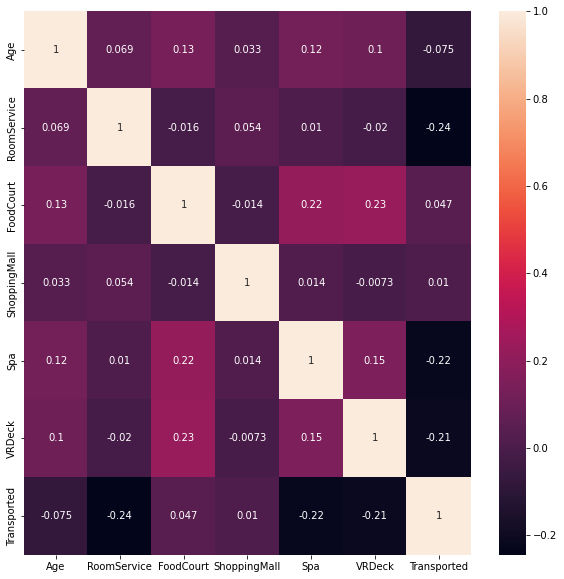

In [14]:
#correlation matrix
corr=train_dataset.corr()
plt.figure(figsize=(10,10))
sns.heatmap(corr,annot=True)

The diagram above depicts the correlation matrix between the numeric variables in the dataset using a heatmap. It is observed that there is no multicollinearity between the independent variables i.e.there is a weak correlation between the variables. 

**Checking the distribution for continuous variables**



In [15]:
#plotting distribution of amount spent on room service
px.histogram(train_dataset,x=train_dataset['RoomService'])

Room Service is not normally distributed.

In [16]:
#plotting distribution of amount spent at the food court
px.histogram(train_dataset,x=train_dataset['FoodCourt'])

Room Service is not normally distributed.

## IV. Handling Missing Data

Remember we concatenated the train and test data set to a dataframe called "whole_dataset". This dataset will be used for data cleaning and preprocessing so both datasets can be the same when modelling.

In [17]:
# this function will go through the data frame and return information on columns with missing values such as the number of missing data in
# each column and the percentage of missing value overall for each column
def info_on_missing_values(df):
  """
      Params: df: dataframe to find missing values from
      
      Returns: dataframe containing information on missing values of input df

  """
  total_missing_values = df.isnull().sum().sort_values(ascending = False)[df.isnull().sum().sort_values(ascending = False) != 0]
  percentage = round(df.isnull().sum().sort_values(ascending = False)/len(df)*100,2)[round(df.isnull().sum().sort_values(ascending = False)/len(df)*100,2) != 0]
  data_type = df.dtypes.sort_values(ascending = False)[df.isnull().sum().sort_values(ascending = False) != 0]
  decription_of_missing_values = pd.concat([total_missing_values, percentage, data_type], axis=1, keys=['Total Missing Val','Percentage','Data Type'])
  return decription_of_missing_values

# showing info on missing values for the wholedataset 
info_on_missing_values(whole_dataset.drop('Transported',axis=1))

,Total Missing Val,Percentage,Data Type
CryoSleep,310,2.39,object
ShoppingMall,306,2.36,float64
Cabin,299,2.31,object
VIP,296,2.28,object
Name,294,2.27,object
FoodCourt,289,2.23,float64
HomePlanet,288,2.22,object
Spa,284,2.19,float64
Destination,274,2.11,object
Age,270,2.08,float64


For each column not a lot of data is missing but if we decide to drop all the columns with na that would make us lose a lot of vital information. 

It is intuitive to think The Passenger ID is not useful for the prediction but the data description discussed some interesting patterns in the column. 

```
PassengerId - A unique Id for each passenger. Each Id takes the form gggg_pp where gggg indicates a group the passenger is travelling with and 
pp is their number within the group.People in a group are often family members, but not always.
```

Example of data in Passenger_id column:

- 0031_01
- 0031_02
- 0031_03

The id's above are for different passengers in the same group. Their group number is **0031** and there are three members in the group.


After critical analysis of the dataset, it is noticed that people from the same group come from the same home planet. Based on this observation, for each group of passengers any member with missing home planet takes on the value of fellow group members.

In [18]:
#spliting the PassengerId feature into group and group number 
whole_dataset['group']= whole_dataset['PassengerId'].apply(lambda x: str(x).split('_')[0])
whole_dataset['group_no']= whole_dataset['PassengerId'].apply(lambda x: str(x).split('_')[1])

#filling the Nan values in HomePlanet by matching people from similar group as they seem to come from the same home planet
whole_dataset['HomePlanet'] = whole_dataset.groupby('group')['HomePlanet'].transform('first')

In [19]:
#checking info on missing values
info_on_missing_values(whole_dataset.drop('Transported',axis=1))

,Total Missing Val,Percentage,Data Type
CryoSleep,310,2.39,object
ShoppingMall,306,2.36,float64
Cabin,299,2.31,object
VIP,296,2.28,object
Name,294,2.27,object
FoodCourt,289,2.23,float64
Spa,284,2.19,float64
Destination,274,2.11,object
Age,270,2.08,float64
VRDeck,268,2.07,float64


The percentage of missing values in Home Planet reduced from 2.22% to 1.21%. This is because passengers that belonged to groups with one member and still had  missing values in Home Planet were left empty.


\\

The rest of the missing values will be filled with the mode or mean 
of the columns for object and numeric variables.

In [20]:
# making a list of columns with missing values
missing_val_cols = whole_dataset.columns[whole_dataset.isna().any()]

# filling columns with missing values with mean or mode
for col in missing_val_cols:
  if whole_dataset[col].dtype == 'object':
      whole_dataset[col]= whole_dataset[col].fillna(whole_dataset[col].mode()[0])
  else:
      whole_dataset[col] = whole_dataset[col].fillna(whole_dataset[col].mean())

info_on_missing_values(whole_dataset)

,Total Missing Val,Percentage,Data Type


We have handled all the missing values :)

## V. Data Preprocessing

After handling the missing values, the non-numeric variables need to be transformed to numeric varables for our model.

In [21]:
#showing non-numeric columns
whole_dataset.select_dtypes(include=['object','bool'])

,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,VIP,Name,Transported,group,group_no
0,0001_01,Europa,False,B/0/P,TRAPPIST-1e,False,Maham Ofracculy,False,0001,01
1,0002_01,Earth,False,F/0/S,TRAPPIST-1e,False,Juanna Vines,True,0002,01
2,0003_01,Europa,False,A/0/S,TRAPPIST-1e,True,Altark Susent,False,0003,01
3,0003_02,Europa,False,A/0/S,TRAPPIST-1e,False,Solam Susent,False,0003,02
4,0004_01,Earth,False,F/1/S,TRAPPIST-1e,False,Willy Santantines,True,0004,01
...,...,...,...,...,...,...,...,...,...,...
12965,9266_02,Earth,True,G/1496/S,TRAPPIST-1e,False,Jeron Peter,True,9266,02
12966,9269_01,Earth,False,G/160/P,TRAPPIST-1e,False,Matty Scheron,True,9269,01
12967,9271_01,Mars,True,D/296/P,55 Cancri e,False,Jayrin Pore,True,9271,01
12968,9273_01,Europa,False,D/297/P,TRAPPIST-1e,False,Kitakan Conale,True,9273,01


There are 7 non-numeric columns. The 

- The PassengerId and Name columns are insignificant and will be dropped.
- The Home Planet column will be transformed to dummy variables to take account of the three home planets.
- The Destination column will be transformed to dummy variables to take account of the three destinations.
- The VIP, CryoSleep, Transported column will be transformed using a label encoder.
- The same transformation done in Cabin column during the exploratory analysis will be carried out here and then will be transformed using a label encoder.
- The group and group_no columns will be converted to integers.


In [22]:
# dropping the passenger id and the name 
whole_dataset.drop(['PassengerId','Name'],axis=1,inplace=True)

# label encoder object
le = preprocessing.LabelEncoder()

#list of columns with bool values
bool_columns = ['CryoSleep','VIP','Transported']

# assign labels of 0 and 1 to values in column
for col in bool_columns:
    whole_dataset[col]=le.fit_transform(whole_dataset[col])

 # list of columns with categorical datatype
categorical_columns = ['HomePlanet','Destination']

# creating dummy variables for the categorical columns
whole_dataset = pd.get_dummies(whole_dataset, prefix=categorical_columns, columns=categorical_columns)

# splitting cabin column to get only Cabin side
whole_dataset['Cabin']= whole_dataset['Cabin'].apply(lambda x: str(x).split('/')[-1])
# label encoding (changing the value in Cabin from S to 1 and P to 0)
whole_dataset= whole_dataset.replace({"Cabin":{'P':0,'S':1}})

whole_dataset['group'] = whole_dataset['group'].astype(str).astype(int)
whole_dataset['group_no'] = whole_dataset['group_no'].astype(str).astype(int)

print("The shape of the whole dataset after transformation: {}".format(whole_dataset.shape))

The shape of the whole dataset after transformation: (12970, 18)


In [23]:
# checking data type of columns in whole_dataset
whole_dataset.dtypes

CryoSleep                      int64
Cabin                          int64
Age                          float64
VIP                            int64
RoomService                  float64
FoodCourt                    float64
ShoppingMall                 float64
Spa                          float64
VRDeck                       float64
Transported                    int64
group                          int64
group_no                       int64
HomePlanet_Earth               uint8
HomePlanet_Europa              uint8
HomePlanet_Mars                uint8
Destination_55 Cancri e        uint8
Destination_PSO J318.5-22      uint8
Destination_TRAPPIST-1e        uint8
dtype: object

In [24]:
whole_dataset.drop('Transported',axis=1,inplace=True)

All the non-numeric variables have been transformed to integers.

## VI. Models

In this section, various classification models will be implemented on our dataset to get the optimal result. 

In [25]:
# separating the whole dataset back to the original train and test dataset
train_set = whole_dataset[:8693] 
test_set = whole_dataset[8693:]

# assigning the target to a variable called "y"
y=train_dataset['Transported']

Some functions have been created to reduce repetition of codes and for efficiency

In [26]:
# this function is used to implement any model 
def implement_model(model,x,y,test_size):
  """
    Params: model: object of the model
            x: dataframe containing the features
            y: the target
            test_size: the proportion to split the data into train and test
    
    Returns: a tuple with the fit model, the accuracy score of the model, the predicted values and the target

  """
  X_train,X_test,y_train,y_test = train_test_split(x,y,test_size=test_size,random_state=2)

  model = model.fit(X_train,y_train)
  score = model.score(X_test,y_test)
  y_pred = model.predict(X_test)

  return model,score,y_pred,y_test

In [27]:
# this function is to implement forward subset selection
def forward_subset_selection(model,X,y,my_test_size=0.2):
  """
    Params: model: object of the model
            x: dataframe containing the features
            y: the target
            test_size: the proportion to split the data into train and test [default = 0.2]
    
    Returns: 1: the best set of features
             2: a list containing the features
             3: a plot showing accuracy of all the subsets (highlighting the best score)

  """
  X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=my_test_size, random_state=3)

  def processSubset(feature_set, X_train, y_train, X_test, y_test):
      # Fit model on feature_set and calculate RSS
      regr = model.fit(X_train[list(feature_set)],y_train)
      accuracy =  regr.score(X_test[list(feature_set)],y_test)
      #accuracy = np.sqrt( np.mean((regr.predict(X_test[list(feature_set)]) - y_test) ** 2) )
      return {'features':feature_set, 'model':regr, 'accuracy':accuracy}

  def forward(predictors, X_train, y_train, X_test, y_test):
   
      # Pull out predictors we still need to process
      remaining_predictors = [p for p in X_train.columns if p not in predictors]
      results = []
      for p in remaining_predictors:
          results.append(processSubset(predictors+[p], X_train, y_train, X_test, y_test))
          #print(p)
      
      # Wrap everything up in a nice dataframe
      models = pd.DataFrame(results)
      #print("----Models tried in this round----\n", models[['features','accuracy']] )
      
      # Choose the model with the highest RSS
      best_model = models.loc[models['accuracy'].argmax()]
      # Return the best model, along with some other useful information about the model
      return best_model

  models_train = pd.DataFrame(columns=['accuracy', 'model','features'])
  predictors = []

  for i in range(1,len(X.columns)+1):  
       
      
      models_train.loc[i] = forward(predictors, X_train, y_train, X_test, y_test)
      predictors = models_train.loc[i]['features']
  

  plt.plot(models_train['accuracy'],'ob')
  plt.xlabel('# Predictors')
  plt.ylabel('accuracy')

  best_n_vars = models_train['accuracy'].argmax()+1
  best_accuracy = models_train['accuracy'].max()
  #Note: the plus 1 accounts for starting at 0 vs at 1 in the indexing
  plt.plot(best_n_vars, best_accuracy, 'or');
  plt.title(f"Best #Vars = {best_n_vars}")
  print("==========")
  print(f"Best number of vars found: {best_n_vars}")
  print(f"Best model found: {models_train.loc[best_n_vars]['features']}")

In [28]:
# this function is used to visualize the classification of the model prediction
def confusion_matrix_plot(y_test,y_pred):
  """
    Params: y_test: the target
            y_pred: the predicted values

    
    Returns: 1: a plot of the confucsion matrix
             2: a classification report 
          

  """
  cm = confusion_matrix(y_test, y_pred)

  fig, ax = plt.subplots(figsize=(8, 8))
  ax.imshow(cm,cmap=plt.cm.Blues)
  ax.grid(False)
  ax.xaxis.set(ticks=(0, 1), ticklabels=('Predicted 0s', 'Predicted 1s'))
  ax.yaxis.set(ticks=(0, 1), ticklabels=('Actual 0s', 'Actual 1s'))
  ax.set_ylim(1.5, -0.5)
  for i in range(2):
      for j in range(2):
          ax.text(j, i, cm[i, j], ha='center', va='center', color='black')
  plt.show()

  print("\n---------------------Classification Report-----------------------")
  return print(classification_report(y_test,y_pred))

In [29]:
# this function prepares a csv document with the final prediction for kaggle submission
def submit_to_kaggle(model,test_set,filename):
  """
    Params: model: object of the model
            test_set: dataframe of test set provided by kaggle
            filename: name of csv file
    
    Returns: creates a csv with the prediction

  """
  pred = model.predict(test_set)
  submit = pd.DataFrame({'PassengerId': test_dataset['PassengerId'], 'Transported':pred}).set_index('PassengerId')
  submit['Transported'].replace([0,1], [False, True], inplace=True)
  submit.to_csv('./{}.csv'.format(filename))

### Discriminant Analysis

Two types of Discriminant analysis have been performed:

- Naive Bayes (using Guassian and Bernoulli)
- Linear Discriminant Analysis



These types of discriminant analysis were chosen based on:
- The nature of the dataset (i.e the number of features and size of the data). 
- The target variable, the task to be performed is binary classification.

#### Naive Bayes classifer

##### Gaussian Naive Bayes Model

In [30]:
# Gaussian Naive Bayes object
gaussian_model = GaussianNB()

# implementing the model 
gaussian_nb_summary = implement_model(gaussian_model,train_set,y,0.2)


gaussian_prediction = gaussian_nb_summary[2]
gaussian_true_target = gaussian_nb_summary[3]
print('The accuracy score for the model: {}'.format(gaussian_nb_summary[1]))

The accuracy score for the model: 0.723404255319149


###### Accuracy of Gaussian Naive Bayes Model

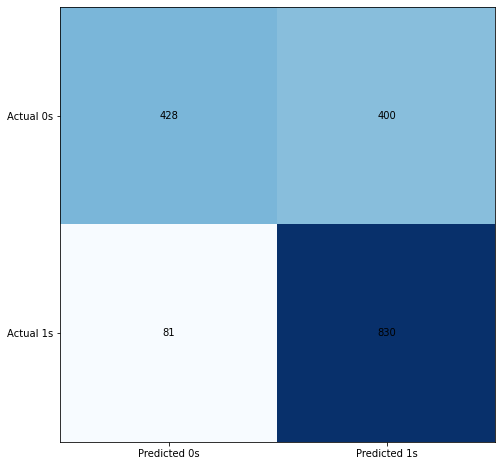


---------------------Classification Report-----------------------
              precision    recall  f1-score   support

       False       0.84      0.52      0.64       828
        True       0.67      0.91      0.78       911

    accuracy                           0.72      1739
   macro avg       0.76      0.71      0.71      1739
weighted avg       0.75      0.72      0.71      1739



In [31]:
# visualization the classification model metrics
confusion_matrix_plot(gaussian_true_target,gaussian_prediction)

The resulting matrix is known as confusion matrix. In the first quadrant the number of entries that were classified correctly with 0 are shown(428). The second and third quadrant sum the incorrect classification(481). Lastly, the fourth quadrant shows the classifications that were done correctly with number 1 (830).

According to the confusion matrix, the gaussian naive bayes model is better at predicting who got transported.

**Precision**: Out of all the passengers that the model predicted would get transported, only 67% actually did.

**Recall**: Out of all the passengers that actually did get transported, the model only predicted this outcome correctly for 91% of those passengers.

It is possible the gaussian naive bayes model did not work well because the data is normally distributed.

**Bernoulli NB** is another type of naive bayes classifier which seems to perform well when the predictors are boolean variables. Since the dataset contains a good number of boolen variables, we try
this approach.

##### Bernoulli Naive Bayes Model

In [32]:
# Bernoulii Naive Bayes object
bernoulli_model = BernoulliNB()

# Implementing the bernoulli model
bernoulli_model_summary = implement_model(bernoulli_model,train_set,y,0.2)

# storing the predicted values from the model on the test set
bernoulli_prediction = bernoulli_model_summary[2]

# storing the true target 
bernoulli_true_target = bernoulli_model_summary[3]

print('The accuracy score for the model: {}'.format(bernoulli_model_summary[1]))

The accuracy score for the model: 0.7435307648073606


The bernoulli models' accuracy score is 74% which is an improvement from the gaussian naive bayes model. However, this can be improved by using forward selection for feature selection.

Best number of vars found: 8
Best model found: ['CryoSleep', 'Age', 'Cabin', 'VIP', 'RoomService', 'VRDeck', 'Spa', 'Destination_55 Cancri e']


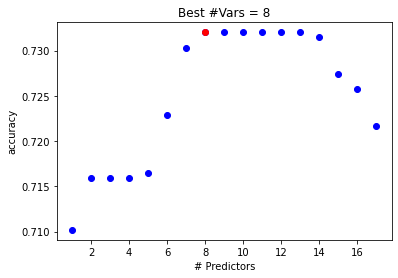

In [33]:
# implement forward selection
forward_subset_selection(bernoulli_model,train_set,y)

In [34]:
#New Bernoulli model object
bernoulli_model_2  = BernoulliNB()

# Implementing the bernoulli model
bernoulli_model_summary_2 = implement_model(bernoulli_model_2,train_set[['CryoSleep', 'Age', 'Cabin', 'VIP', 'RoomService', 'VRDeck', 'Spa', 'Destination_55 Cancri e']],y,0.2)



###### Accuracy of Bernoulli Naive Bayes Model

In [35]:
# storing the predicted values from the model on the test set
bernoulli_prediction_2 = bernoulli_model_summary_2[2]

# storing the true target 
bernoulli_true_target_2 = bernoulli_model_summary_2[3]

print('The accuracy score for the model: {}'.format(bernoulli_model_summary_2[1]))

The accuracy score for the model: 0.7475560667050029


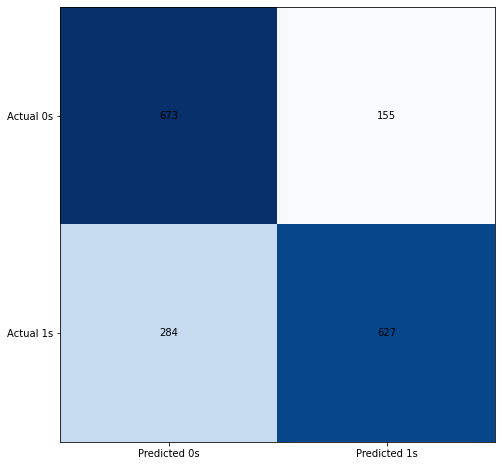


---------------------Classification Report-----------------------
              precision    recall  f1-score   support

       False       0.70      0.81      0.75       828
        True       0.80      0.69      0.74       911

    accuracy                           0.75      1739
   macro avg       0.75      0.75      0.75      1739
weighted avg       0.75      0.75      0.75      1739



In [36]:
# visualization the classification model metrics
confusion_matrix_plot(bernoulli_true_target_2,bernoulli_prediction_2)

The resulting matrix is known as confusion matrix. In the first quadrant the number of entries that were classified correctly with 0 are shown(673). The second and third quadrant sum the incorrect classification(439). Lastly, the fourth quadrant shows the classifications that were done correctly with number 1 (627).


**Precision**: Out of all the passengers that the model predicted would get transported, only 80% actually did.

**Recall**: Out of all the passengers that actually did get transported, the model only predicted this outcome correctly for 69% of those passengers.



In [37]:
# making predictioin for the kaggle test set with the bernoulli model and selected variables 
submit_to_kaggle(bernoulli_model_summary_2[0],test_set[['CryoSleep', 'Age', 'Cabin', 'VIP', 'RoomService', 'VRDeck', 'Spa', 'Destination_55 Cancri e']],'bernoulli_submission')

This is the score for the bernoulli naive bayes model

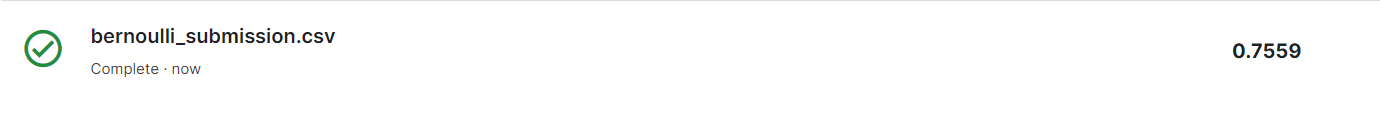

#### Linear Discriminant Analysis

In [38]:
# splitting the train set provided by kaggle into train and test set
X_train, X_test, y_train, y_test = train_test_split(train_set, y, test_size=0.2, random_state=2)

# Linear Discriminant Analysis object
lda_model = LinearDiscriminantAnalysis()

# fit the model with the train set
x_lda = lda_model.fit_transform(X_train, y_train)


In [39]:
train_set.shape

(8693, 17)

##### Accuracy of Linear Discriminant Analysis

In [40]:
# calculating the accuracy score for the test set
lda_pred_score = lda_model.score(X_test,y_test)

print("The accuracy score of the model: {}".format(lda_pred_score))

The accuracy score of the model: 0.7705577918343876


In [41]:
# showing the explained variance of the lda model
lda_model.explained_variance_ratio_

array([1.])

The explained variance ratio computes the amount of variance that each LDA component "explains", since we have only 2 classes, there will be only 1 component (n-1) where n is the number of classes. 



Text(0.5, 0, 'LD1')

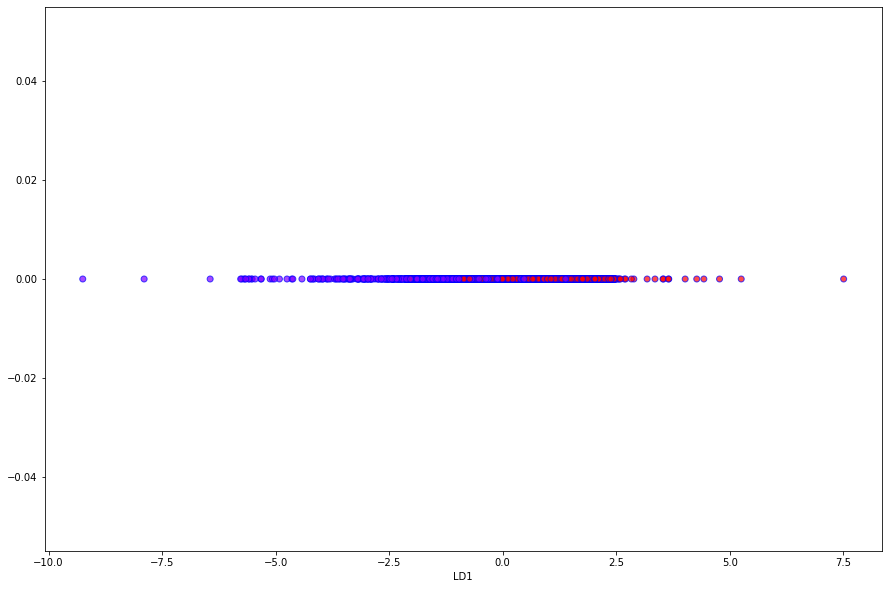

In [42]:
# ploting the 
a= [0]*len(x_lda[:,0])
plt.figure(figsize=(15,10))
plt.scatter(
    x_lda[:,0],
    a,
    c=y_train,
    cmap='rainbow',
    alpha=0.7,
    edgecolors='b'
)
plt.xlabel("LD1")

According to the LDA functionality, it increases the interclass variance and reduces within the class variance. From the figure, it is evident that the LDA model fit does not do a good job in seperating the 2 classes.



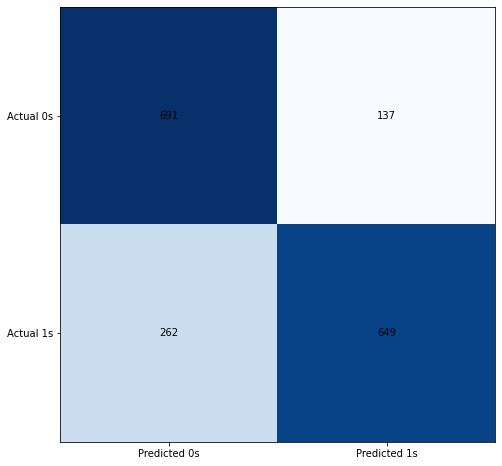


---------------------Classification Report-----------------------
              precision    recall  f1-score   support

       False       0.73      0.83      0.78       828
        True       0.83      0.71      0.76       911

    accuracy                           0.77      1739
   macro avg       0.78      0.77      0.77      1739
weighted avg       0.78      0.77      0.77      1739



In [43]:
lda_predict = lda_model.predict(X_test)


# visualization the classification model metrics
confusion_matrix_plot(y_test,lda_predict)

The resulting matrix is known as confusion matrix. In the first quadrant the number of entries that were classified correctly with 0 are shown(691). The second and third quadrant sum the incorrect classification(399). Lastly, the fourth quadrant shows the classifications that were done correctly with number 1 (649).



**Precision**: Out of all the passengers that the model predicted would get transported, only 83% actually did.

**Recall**: Out of all the passengers that actually did get transported, the model only predicted this outcome correctly for 77% of those passengers.

It is an improvement from the Naive Bayes Model.

In [44]:
# making predictioin for the kaggle test set with the linear discriminant model
submit_to_kaggle(lda_model,test_set,'final_lda_submission')

This is the score for the linear discriminant analysis model

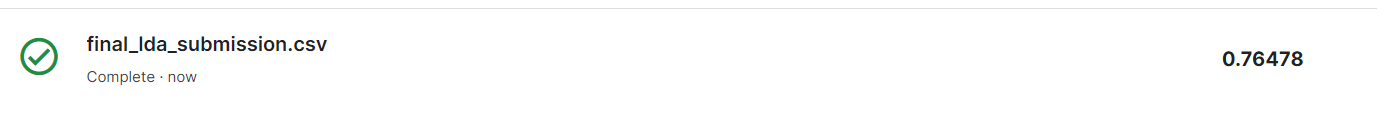

### Logistic Regression

Here we will fit model with all the variables first.

In [45]:
# Logistic Regression
lg = LogisticRegression()

# Implementing the logistic regression model
logistic_reg_summary = implement_model(lg,train_set,y,0.2)


# storing the predicted values from the model on the test set
lg_prediction = logistic_reg_summary[2]

# storing the true target 
lg_true_target = logistic_reg_summary[3]

print('The accuracy score for the model: {}'.format(logistic_reg_summary[1]))

The accuracy score for the model: 0.7918343875790684


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning:

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression



The logistic model fit with all the features gives an accuracy score of 0.79. 
From the exploratory analysis, it was observed that there are some insignificant features in the dataset which affects the model performance, thus to improve the score, backward elimination will be performed to select the best set of features for the logistic regression model.



In [46]:
# splitting the train set provided by kaggle into train and test set
X_train, X_test, y_train, y_test = train_test_split(train_set, y, test_size=0.2, random_state=2)

# backward elimination using the p_value
features = list(X_train.columns)
columns_removed ={}
pmax = 1
while (len(features)>0):
    verbose = False
    p= []
    X_1 = X_train[features]
    X_1 = sm.add_constant(X_1)
    model = sm.GLM(y_train,X_1, family=sm.families.Binomial()).fit()
    #logm1.fit().summary()
    #model3 = sm.OLS(Y,X_1).fit()
    p = pd.Series(model.pvalues.values[1:],index = features)      
    pmax = max(p)
    feature_with_p_max = p.idxmax()
    if(pmax>0.05):
        #columns_removed.append(feature_with_p_max)
        features.remove(feature_with_p_max)
        columns_removed[feature_with_p_max] = \
           pmax
    else:
        break

# list of selected features using backward elimation        
selected_features_BE = features


/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/tsatools.py:142: FutureWarning:

In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/tsatools.py:142: FutureWarning:

In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/tsatools.py:142: FutureWarning:

In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/tsatools.py:142: FutureWarning:

In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/tsatools.py:142: FutureWarning:

In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only



In [47]:
print("Selected features: {}".format(selected_features_BE))

Selected features: ['CryoSleep', 'Cabin', 'Age', 'RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck', 'group', 'HomePlanet_Earth', 'HomePlanet_Europa', 'HomePlanet_Mars', 'Destination_55 Cancri e']


In [48]:
# create a new Logistic regression object
ad = LogisticRegression()

# Implementing the logistic regression model
model_summary = implement_model(ad,X_train[selected_features_BE],y_train,0.2)




/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning:

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression



##### Accuracy of Logistic Regression

In [49]:
# storing the predicted values from the model on the test set
lg_prediction_2 = model_summary[2]

# storing the true target 
lg_true_target_2 = model_summary[3]

print('The accuracy score for the model: {}'.format(model_summary[1]))

The accuracy score for the model: 0.803019410496046


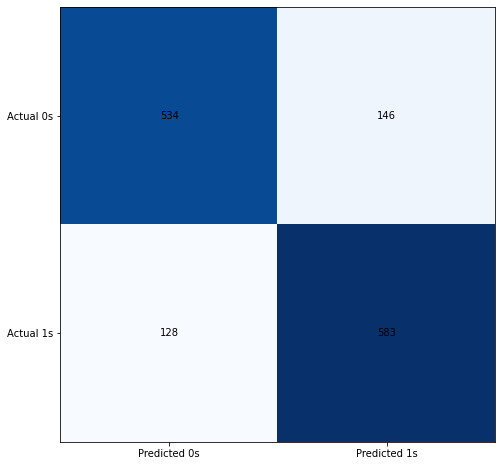


---------------------Classification Report-----------------------
              precision    recall  f1-score   support

       False       0.81      0.79      0.80       680
        True       0.80      0.82      0.81       711

    accuracy                           0.80      1391
   macro avg       0.80      0.80      0.80      1391
weighted avg       0.80      0.80      0.80      1391



In [50]:
# visualization the classification model metrics
confusion_matrix_plot(lg_true_target_2,lg_prediction_2)

The resulting matrix is known as confusion matrix. In the first quadrant the number of entries that were classified correctly with 0 are shown(534). The second and third quadrant sum the incorrect classification(274). Lastly, the fourth quadrant shows the classifications that were done correctly with number 1 (583).

According to the confusion matrix, the logistic regression model with the selected variables misclassify's the least.


**Precision**: Out of all the passengers that the model predicted would get transported, only 80% actually did.

**Recall**: Out of all the passengers that actually did get transported, the model only predicted this outcome correctly for 82% of those passengers.


In [51]:
# making prediction for the kaggle test set with the logistic regression model
submit_to_kaggle(model_summary[0],test_set[selected_features_BE],'logistic_reg')

This is the score for the logistic regression model

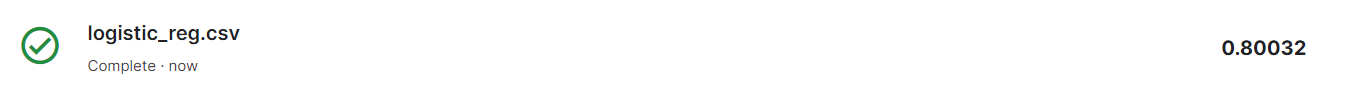

# 4. Interpretation

## Comparison of Discriminant Analysis & Logistic Regression (using AUC-ROC Curve)

The binary classification model's performance is evaluated using the Receiver Operator Characteristic (ROC) curve. The area under the curve is used to determine how successfully our classifiers distinguish between classes.

In [52]:
# storing the predicted probabality for each model 
pred_prob1 = model_summary[0].predict_proba(X_test[selected_features_BE])
pred_prob2 = lda_model.predict_proba(X_test)
pred_prob3 = bernoulli_model_summary_2[0].predict_proba(X_test[['CryoSleep', 'Age', 'Cabin', 'VIP', 'RoomService', 'VRDeck', 'Spa', 'Destination_55 Cancri e']])

In [53]:
# get the auc scores
auc_score1 = roc_auc_score(y_test, pred_prob1[:,1])
auc_score2 = roc_auc_score(y_test, pred_prob2[:,1])
auc_score3 = roc_auc_score(y_test, pred_prob3[:,1])

print("The area under the curve for Logistic Regression: {}".format(auc_score1))
print("The area under the curve for Linear Discirminant Analysis {}".format(auc_score2))
print("The area under the curve for Bernoulli Naive Bayes: {}".format(auc_score1))

The area under the curve for Logistic Regression: 0.8752631551037509
The area under the curve for Linear Discirminant Analysis 0.8638500453395695
The area under the curve for Bernoulli Naive Bayes: 0.8752631551037509


In [54]:
# roc curve for models
fpr1, tpr1, thresh1 = roc_curve(y_test, pred_prob1[:,1], pos_label=1)
fpr2, tpr2, thresh2 = roc_curve(y_test, pred_prob2[:,1], pos_label=1)
fpr3, tpr3, thresh3 = roc_curve(y_test, pred_prob3[:,1], pos_label=1)

# roc curve for tpr = fpr 
random_probs = [0 for i in range(len(y_test))]
p_fpr, p_tpr, _ = roc_curve(y_test, random_probs, pos_label=1)

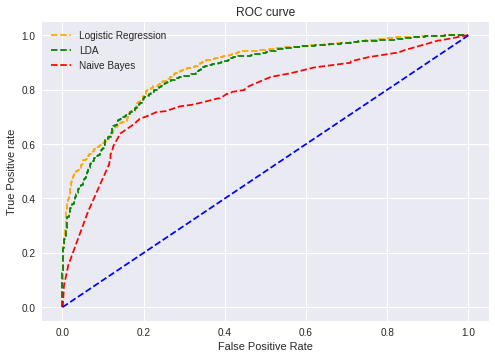

In [55]:
plt.style.use('seaborn')

# plot roc curves
plt.plot(fpr1, tpr1, linestyle='--',color='orange', label='Logistic Regression')
plt.plot(fpr2, tpr2, linestyle='--',color='green', label='LDA')
plt.plot(fpr3, tpr3, linestyle='--',color='red', label='Naive Bayes')
plt.plot(p_fpr, p_tpr, linestyle='--', color='blue')
# title
plt.title('ROC curve')
# x label
plt.xlabel('False Positive Rate')
# y label
plt.ylabel('True Positive rate')

plt.legend(loc='best')
plt.savefig('ROC',dpi=300)
plt.show();

It is evident from the plot that the AUC for the Logistic Regression ROC curve is higher than that for the LDA and Naive Bayes ROC curve. Therefore, we can say that logistic regression did a better job of classifying the positive class in the dataset.

## Interpretation of Logistic Regression

### Number of Variables

In our final model, we've been able to improve our model by using only 13 variables instead of using all 17 variables. This suggests that the variables which were ommited such as the VIP status of the a passenger did not impact the model prediction significantly.

### Interpretation of coefficients

The coefficient of the model represents the log-odds ratio so to interpret model, the coefficients are exponentiated.

In [56]:
list_of_col = selected_features_BE

# print out model variable coefficients
est_coef = pd.Series(index=list_of_col, data=np.exp(model_summary[0].coef_[0]))

est_order = est_coef.abs().sort_values(ascending=False).index.tolist()

print("----- Coefficients in Logistic Regressions -------")
for i in range(0,len(X_train[selected_features_BE].columns)-1):
    if model_summary[0].coef_[0][i] == 0:
        print("{}:{}".format(list_of_col[i],model_summary[0].coef_[0][i]))
        
print('-------Top 10 Features with high estimates ---------')
print(est_coef[est_order][:10])

----- Coefficients in Logistic Regressions -------
-------Top 10 Features with high estimates ---------
CryoSleep                  3.020216
HomePlanet_Europa          2.366149
Cabin                      1.772043
Destination_55 Cancri e    1.616767
HomePlanet_Mars            1.371114
FoodCourt                  1.000530
ShoppingMall               1.000378
group                      1.000026
VRDeck                     0.998267
RoomService                0.998175
dtype: float64


- The odds of being transported to another dimension is 3 times higher if the passenger is in CryoSleep and all other variables are constant.
- The odds of being transported to another dimension is 136% higher if the passenger is from Europa and all other variables are constant.
- The odds of being transported to another dimension is 77% higher when the passenger is on the Starboard side of the cabin and all other variables are constant.
-The odds of being transported to another dimension barely changes with expenditure  variables (i.e expenses spent of Food Court, at the shopping mall, VR deck etc).

## Conclusion

After implementing multiple classification models to perform this binary classification task, logistic regression coupled with backward elimination proved to perform the best out of all the others.

# References

- https://www.statology.org/linear-discriminant-analysis-in-python/
- https://towardsdatascience.com/naive-bayes-classifier-81d512f50a7c
- https://towardsdatascience.com/a-simple-interpretation-of-logistic-regression-coefficients-e3a40a62e8cf
- https://www.analyticsvidhya.com/blog/2020/06/auc-roc-curve-machine-learning/